In [110]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from matplotlib import style
from pandas.plotting import scatter_matrix
import numpy as np

In [72]:
#select time-lapse
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)


In [73]:
df = web.DataReader("AAPL", 'yahoo', start, end)
close_px = df['Adj Close']
#sacar media, interpolar
mavg = close_px.rolling(window=200).mean()
#print((mavg))
#probar con EMCEE python package

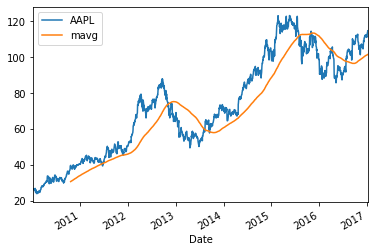

In [74]:
#plotting
close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()
plt.show()

Return Deviation — to determine risk and return
Expected Return measures the mean, or expected value, of the probability distribution of investment returns. The expected return of a portfolio is calculated by multiplying the weight of each asset by its expected return and adding the values for each investment — Investopedia.
Following is the formula you could refer to:
R(t) = P(t) - P(t-1) / P(t-1) = P(t)/P(t-1) - 1

use Pandas dataframe.shift() function Shift index by desired number of periods with an optional time freq. This function takes a scalar parameter called period, which represents the number of shifts to be made over the desired axis. This function is very helpful when dealing with time-series data.
https://www.geeksforgeeks.org/python-pandas-dataframe-shift/

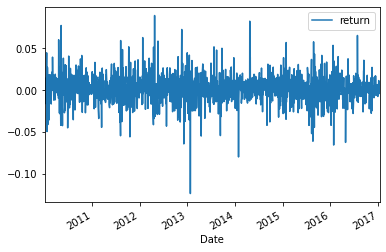

In [75]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')
plt.legend()
plt.show()

In [76]:
#comparando otras acciones y correlacionar datos!
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [77]:
#print(dfcomp)

Correlation Analysis — Does one competitor affect others?
We can analyse the competition by running the percentage change and correlation function in pandas. Percentage change will find how much the price changes compared to the previous day which defines returns. Knowing the correlation will help us see whether the returns are affected by other stocks’ returns

Pandas pct_change() method is applied on series with numeric data to calculate Percentage change after n number of elements. By default, it calculates percentage change of current element from the previous element.

In [78]:
#Pandas pct_change() method is applied on series 
#with numeric data to calculate Percentage change 
#after n number of elements. By default, 
#it calculates percentage change of current element 
#from the previous element.

retscomp = dfcomp.pct_change()
#print(retscomp)

#DataFrame.corr(self, method='pearson', min_periods=1)
#dataframe.corr() is used to find the pairwise correlation 
#of all columns in the dataframe.
corr = retscomp.corr()
print(corr)

Symbols      AAPL        GE      GOOG       IBM      MSFT
Symbols                                                  
AAPL     1.000000  0.381475  0.411708  0.383816  0.393525
GE       0.381475  1.000000  0.422261  0.535149  0.474111
GOOG     0.411708  0.422261  1.000000  0.403004  0.472081
IBM      0.383816  0.535149  0.403004  1.000000  0.496582
MSFT     0.393525  0.474111  0.472081  0.496582  1.000000


Text(0, 0.5, 'Returns GE')

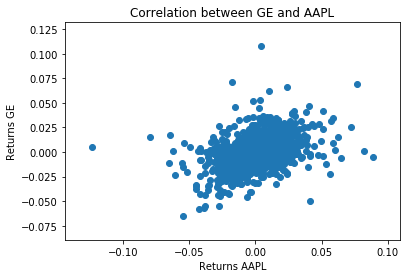

In [79]:
# Let’s plot Apple and GE with ScatterPlot to view their return distributions
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.title("Correlation between GE and AAPL")
plt.xlabel("Returns AAPL")
plt.ylabel("Returns GE")

#We can see here that there are slight positive correlations 
among GE returns and Apple returns.
Let us improve our analysis by plotting the scatter_matrix to visualize 
possible correlations among competing stocks.
At the diagonal point, we will run Kernel Density Estimate (KDE). 

From here we could see most of the distributions among stocks which 
approximately positive correlations.




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9802d14cc0>,
      dtype=object)

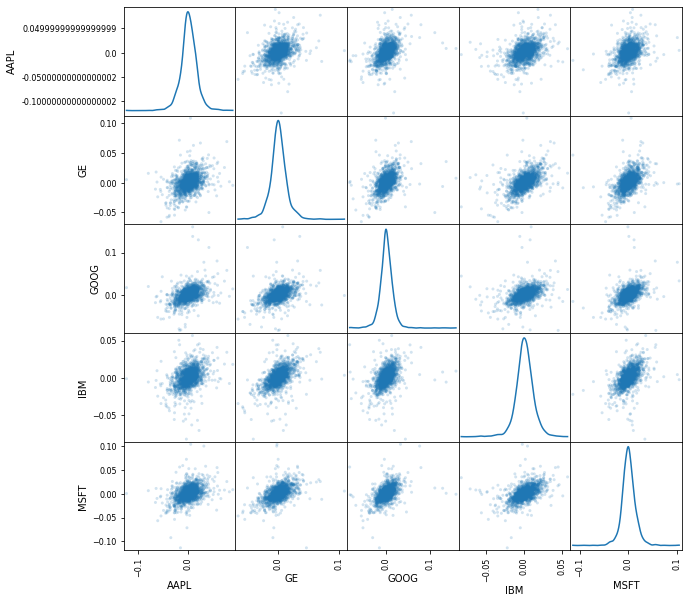

In [80]:
from pandas.plotting import scatter_matrix

pd.plotting.scatter_matrix(retscomp, diagonal="kde", alpha=0.2, figsize=(10, 10))

#KDE is a fundamental data smoothing problem where inferences about 
#the population are made, based on a finite data sample. 
#It helps generate estimations of the overall distributions.

To prove the positive correlations, we will use heat maps to 
visualize the correlation ranges among the competing stocks. 
Notice that the lighter the color, the more correlated the two stocks are.

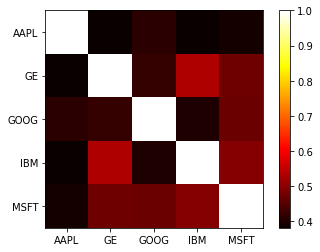

In [81]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

From the Scatter Matrix and Heatmap, we can find great correlations among the competing stocks. However, this might not show causality, and could just show the trend in the technology industry rather than show how competing stocks affect each other.

# Stocks Returns Rate and Risk
Apart from correlation, we also analyse each stock’s risks and returns. 
In this case we are extracting the average of returns (Return Rate) 
and the standard deviation of returns (Risk).

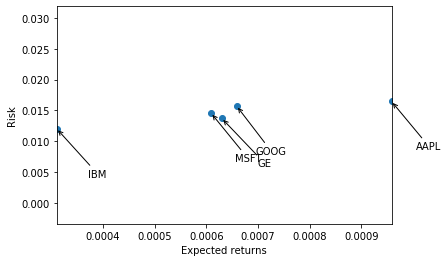

In [124]:
%matplotlib inline
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
plt.xlim(min(retscomp.mean()), max(retscomp.mean()))
#plt.ylim(min(retscomp.mean()), max(retscomp.mean()))
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, -50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        #bbox = dict(boxstyle = 'round,pad=0.1', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

Logically, you would like to minimize the risk and maximize returns. Therefore, 
you would want to draw the line for your risk-return tolerance (The red line). 
You would then create the rules to buy those stocks under the red line (MSFT, GE, and IBM) 
and sell those stocks above the red line (AAPL and GOOG). This red line showcases 
your expected value threshold and your baseline for buy/sell decision.

# Predicting Stocks Price
We will use these three machine learning models to predict our stocks: Simple Linear Analysis, Quadratic Discriminant Analysis (QDA), and K Nearest Neighbor (KNN). But first, let us engineer some features: High Low Percentage and Percentage Change.

DataFrame.loc
Access a group of rows and columns by label(s) or a boolean array.

In [96]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0

In [98]:
#print(dfreg)

# Pre-processing & Cross Validation
We will clean up and process the data using the following steps before putting them into the prediction models:
1) Drop missing value
2) Separating the label here, we want to predict the AdjClose
3) Scale the X so that everyone can have the same distribution for linear regression
4) Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
5) Separate label and identify it as y
6) Separation of training and testing of model by cross validation train test split

In [106]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)


In [108]:
# We want to separate 1 percent of the data to forecast
import math
forecast_out = int(math.ceil(0.01 * len(dfreg)))

In [111]:
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [119]:
# Scale the X so that everyone can have the same distribution for linear regression
from sklearn import preprocessing
X = preprocessing.scale(X)
print(X)

[[-1.65177687  0.47910776 -0.81078903  0.22227455]
 [-1.65009338  0.92892913 -0.72471323 -0.0579512 ]
 [-1.66560672  0.72207697  0.15554417 -1.17213957]
 ...
 [ 1.40195401 -0.8465245  -0.04889354  0.90670559]
 [ 1.40195401 -1.00789852 -0.75235401  0.11643395]
 [ 1.42398016 -0.80010659 -0.55105627  0.304334  ]]


In [115]:
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [116]:
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

# Model Generation — Where the prediction fun starts
But first, let’s insert the following imports for our Scikit-Learn:

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# Simple Linear Analysis & Quadratic Discriminant Analysis
Simple Linear Analysis shows a linear relationship between two or more variables. When we draw this relationship within two variables, we get a straight line. Quadratic Discriminant Analysis would be similar to Simple Linear Analysis, except that the model allowed polynomial (e.g: x squared) and would produce curves.

Linear Regression predicts dependent variables (y) as the outputs given independent variables (x) as the inputs. During the plotting, this will give us a straight line as shown below:

We will plug and play the existing Scikit-Learn library and train the model by selecting our X and y train sets.


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [130]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [131]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [132]:
# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

K Nearest Neighbor (KNN)
This KNN uses feature similarity to predict values of data points. This ensures that the new point assigned is similar to the points in the data set. To find out similarity, we will extract the points to release the minimum distance (e.g: Euclidean Distance).

In [133]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

Evaluation
A simple quick and dirty way to evaluate is to use the score method in each trained model. The score method finds the mean accuracy of self.predict(X) with y of the test data set.

In [134]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)


In [135]:
# results
('The linear regression confidence is ', 0.96399641826551985)
('The quadratic regression 2 confidence is ', 0.96492624557970319)
('The quadratic regression 3 confidence is ', 0.9652082834532858)
('The knn regression confidence is ', 0.92844658034790639)

('The knn regression confidence is ', 0.9284465803479064)

In [ ]:
This shows an enormous accuracy score (>0.95) for most of the models. 
However this does not mean we can blindly place our stocks. 
There are still many issues to consider, especially with different 
companies that have different price trajectories over time.
For sanity testing, let us print some of the stocks forecast.

In [ ]:
For sanity testing, let us print some of the stocks forecast:

In [151]:
# choose: clf = clfknn, clfpoly3, clfpoly2, clfreg
clf = clfknn
forecast_set = clf.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set)

[112.58226395 107.5148735  106.88648987 108.24702454 109.12851334
 104.01942062 111.00417709 102.93068314 108.24702454 102.93068314
 103.8321228  106.88648987  96.959095   110.25295258 114.43230438
 102.95124817 114.43230438 102.95124817]


# Plotting the Prediction
Based on the forecast, we will visualize the plot with our existing historical data. This will help us visualize how the model fares to predict future stocks pricing.

In [146]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

In [147]:
for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

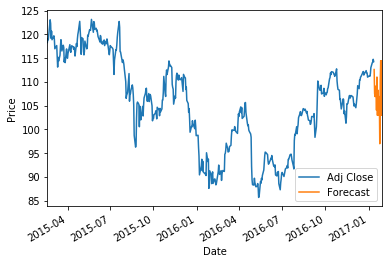

In [148]:
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

As we can see the blue color showcased the forecast on the stocks price based on regression. The forecast predicted that there would be a downturn for not too long, then it will recover. Therefore, we could buy the stocks during downturn and sell during upturn.